## Cimetidine tutorial: indexing, spacegroup determination & structure solution
In this notebook, you can:
* Load the powder diffraction data and create the PowderPattern object
* Find the diffraction peaks and index them (determine the unit cell)
* Perform a profile fit to optimise the background and reflection profiles
* Determine the spacegroup
* Add a molecule to describe the contents of the Crystal structure
* Solve the Crystal structure using a Monte-Carlo/Parallel tempering algorithm
* Save the best result to a CIF file and to Fox .xmlgz format

Notes:
* This is an *ideal* case for structure solution from powder diffraction - a clean powder diffraction data easily indexed, an unambiguous spacegroup, and a relatively simple structure.
* It is important to follow the steps relatively linearly and avoid going back to previous cells until you know better. For example to avoid adding multiple times Scatterer/Molecule objects in the crystal structure, or multiple crystalline phases to the powder pattern with the same crystal, etc...

### Imports

In [1]:
# 'notebook' allows live update. Otherwise 'widget', 'ipympl', 'inline' can be used
%matplotlib notebook

import os
import pyobjcryst
import numpy as np
import matplotlib.pyplot as plt
from pyobjcryst.crystal import *
from pyobjcryst.powderpattern import *
from pyobjcryst.indexing import *
from pyobjcryst.molecule import *
from pyobjcryst.globaloptim import MonteCarlo
from pyobjcryst.io import xml_cryst_file_save_global

### Create powder pattern object, download data if necessary

<IPython.core.display.Javascript object>


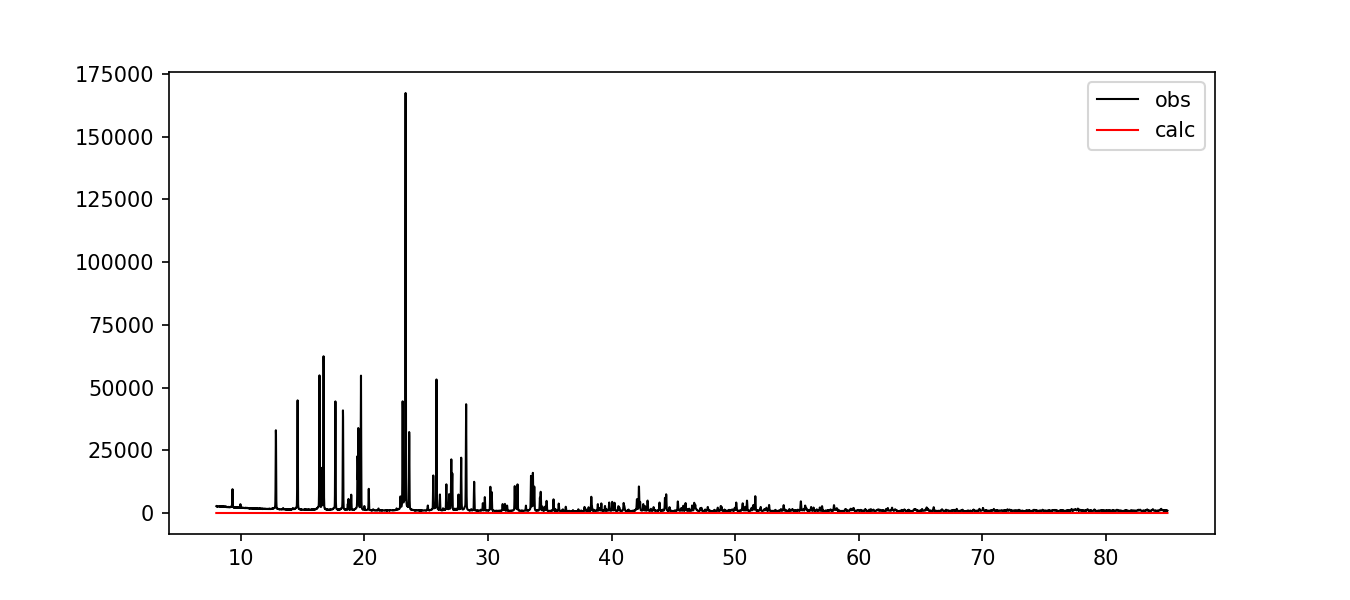

In [2]:
p = PowderPattern()
if not os.path.exists("cime.dat"):
    os.system("curl -O https://raw.githubusercontent.com/vincefn/objcryst/master/Fox/example/tutorial-cimetidine/cime.dat")
p.ImportPowderPatternFullprof("cime.dat")
p.SetWavelength(1.52904)

p.plot()

### Find peaks & index the reflections
In this case the peaks are automatically found without any parasitic phase.

And the unit cell is also indexed without any ambiguity. This uses the dichotomy in volume approach (Louër & Boultif).

... It is not always that easy !

In [3]:
# Index
pl = p.FindPeaks(1.5, -1, 1000)
if len(pl) > 20:
    pl.resize(20)  # Only keep 20 peaks
for peak in pl:
    print(peak)

ex = quick_index(pl)

print("Solutions:")
for s in ex.GetSolutions():
    print(s)

Peak dobs=0.10632+/-0.00011 iobs=2.146855e+04 (? ? ?))
Peak dobs=0.11354+/-0.00011 iobs=4.111350e+03 (? ? ?))
Peak dobs=0.14620+/-0.00011 iobs=9.429778e+04 (? ? ?))
Peak dobs=0.15277+/-0.00011 iobs=1.388049e+03 (? ? ?))
Peak dobs=0.16177+/-0.00011 iobs=1.420839e+03 (? ? ?))
Peak dobs=0.16602+/-0.00014 iobs=1.141690e+05 (? ? ?))
Peak dobs=0.18616+/-0.00011 iobs=1.609675e+05 (? ? ?))
Peak dobs=0.18839+/-0.00011 iobs=4.474511e+04 (? ? ?))
Peak dobs=0.18984+/-0.00011 iobs=1.839251e+05 (? ? ?))
Peak dobs=0.20064+/-0.00011 iobs=1.290410e+05 (? ? ?))
Peak dobs=0.20760+/-0.00011 iobs=1.182234e+05 (? ? ?))
Peak dobs=0.21186+/-0.00006 iobs=2.198665e+03 (? ? ?))
Peak dobs=0.21262+/-0.00011 iobs=8.717511e+03 (? ? ?))
Peak dobs=0.21507+/-0.00011 iobs=1.818877e+04 (? ? ?))
Peak dobs=0.22072+/-0.00008 iobs=2.098754e+04 (? ? ?))
Peak dobs=0.22153+/-0.00011 iobs=6.288388e+04 (? ? ?))
Peak dobs=0.22394+/-0.00011 iobs=1.562582e+05 (? ? ?))
Peak dobs=0.22705+/-0.00014 iobs=3.681909e+03 (? ? ?))
Peak dobs=

### Create a crystal phase using the indexed unit cell

<IPython.core.display.Javascript object>


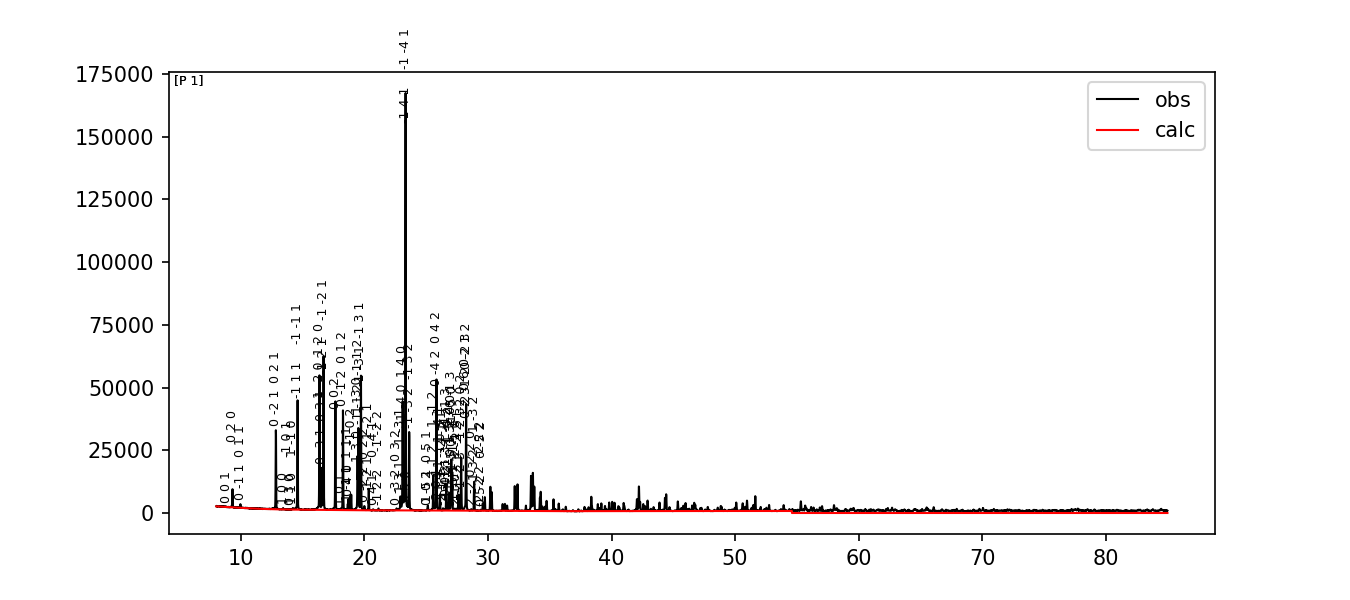

In [4]:
uc = ex.GetSolutions()[0][0].DirectUnitCell()
c = pyobjcryst.crystal.Crystal(uc[0], uc[1], uc[2], uc[3], uc[4], uc[5], "P1")
pdiff = p.AddPowderPatternDiffraction(c)

# Plot with indexing in new figure
p.plot(diff=False,fig=None,hkl=True)

### Fit the profile and background
We use a maximum sin(theta)/lambda because we don't really need high angle/high resolution data.

This will go faster and is more reliable for spacegroup indexing and structure solution.

No background, adding one automatically
Selected PowderPatternDiffraction:    with Crystal:  
Profile fitting finished.
Remember to use SetExtractionMode(False) on the PowderPatternDiffraction object
to disable profile fitting and optimise the structure.


<IPython.core.display.Javascript object>


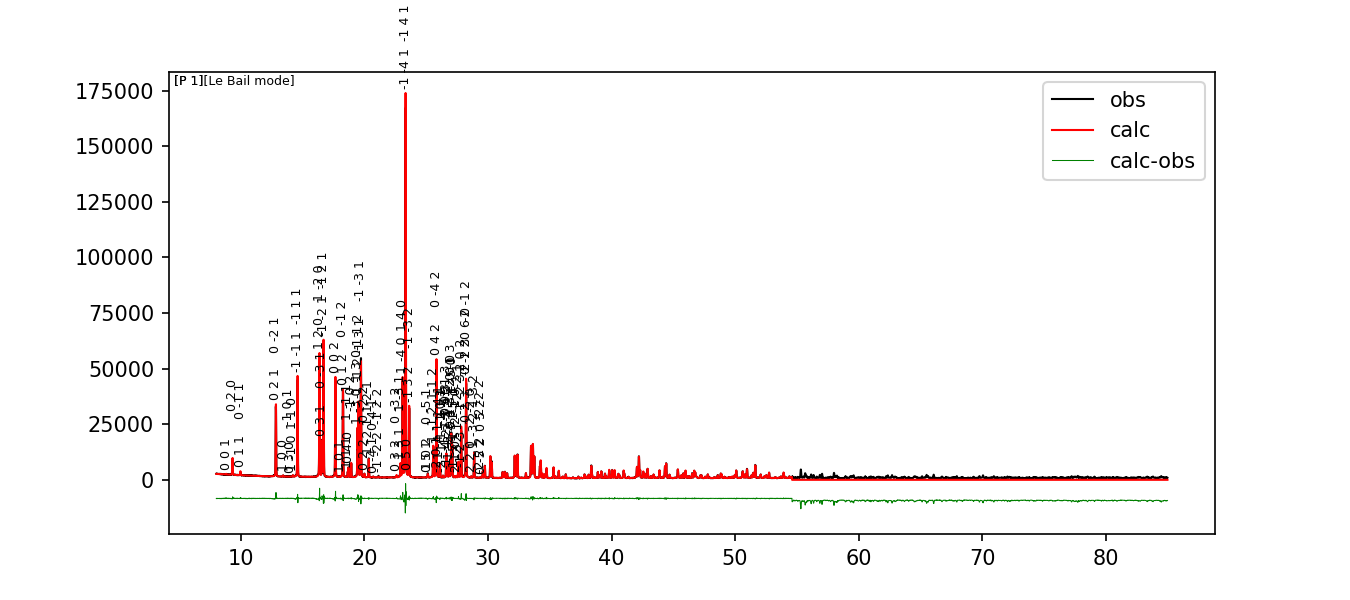

Fit result: Rw=  5.52% Chi2=  34151.69  GoF=    4.44  LLK=  6335.238


In [5]:
p.SetMaxSinThetaOvLambda(0.3)
p.quick_fit_profile(auto_background=True,plot=False, init_profile=True,verbose=True)
p.quick_fit_profile(plot=False, init_profile=False, asym=True, displ_transl=True, verbose=False)

# Plot in new figure
p.plot(diff=True, fig=None, hkl=True)
print("Fit result: Rw=%6.2f%% Chi2=%10.2f  GoF=%8.2f  LLK=%10.3f" %
      (p.rw * 100, p.chi2, p.chi2/p.GetNbPointUsed(), p.llk))

### Find the spacegroup
The SpaceGroupExplorer can be used to find the optimal spacegroup. 

What `RunAll()` does is try all spacegroups and settings which are compatible with the unit cell (in this case all monoclinic and triclinic), and perform a profile fit (Le Bail only, we don't refine profile parameters or background since these parameters should be OK).

From this several values are extracted for each spacegroup setting:
* **Rw** - the standard full-profile weighted R factor $R_{wp}$
* **GoF**: the chi2 (full profile  $\chi^2=\Sigma\frac{(obs-calc)^2}{\sigma^2}$) divided by the number of points used
* **nGoF**: this is the Goodness-of-Fit, but computed on integration intervals defined by P1 reflections, and then multipled by the number of reflections used divided by the number of reflections for the P1 spacegroup. This is more discriminating and allows to put forward spacegroups which yield a good fit with more extinctions.
* **reflections** is the number of reflections actually taken into account for this spacegroup up to the maximum sin(theta)/lambda
* **extinct446** gives the number of extinct reflections for 0<=H<=4 0<=K<=4 0<=L<=6 (which is used internally as a unique fingerprint for the extinctions)

Some C++ verbose output does not appear here but will be in the jupyter server log if you see it.

The results are sorting by ascending **nGOF**


P 1 21/c 1    nGoF=   1.5207 GoF=  13.605 Rw= 6.51 [ 92 reflections, extinct446= 17]
P 1 c 1       nGoF=   1.7061 GoF=  13.957 Rw= 6.59 [ 96 reflections, extinct446= 15]
P 1 2/c 1     nGoF=   1.7061 GoF=  13.957 Rw= 6.59 [ 96 reflections, extinct446= 15]
P 1 21 1      nGoF=   1.7398 GoF=  14.129 Rw= 6.62 [101 reflections, extinct446=  2]
P 1 21/m 1    nGoF=   1.7398 GoF=  14.129 Rw= 6.62 [101 reflections, extinct446=  2]
P 1 2 1       nGoF=   1.9400 GoF=  14.483 Rw= 6.70 [105 reflections, extinct446=  0]
P 1 m 1       nGoF=   1.9400 GoF=  14.483 Rw= 6.70 [105 reflections, extinct446=  0]
P 1 2/m 1     nGoF=   1.9400 GoF=  14.483 Rw= 6.70 [105 reflections, extinct446=  0]
P 1           nGoF=   3.3664 GoF=  14.769 Rw= 6.76 [186 reflections, extinct446=  0]
P -1          nGoF=   3.3664 GoF=  14.769 Rw= 6.76 [186 reflections, extinct446=  0]
P 1 21/n 1    nGoF=   5.4729 GoF=  26.814 Rw= 9.13 [ 92 reflections, extinct446= 19]
P 1 2/n 1     nGoF=   5.8324 GoF=  27.183 Rw= 9.19 [ 96 reflectio

<IPython.core.display.Javascript object>


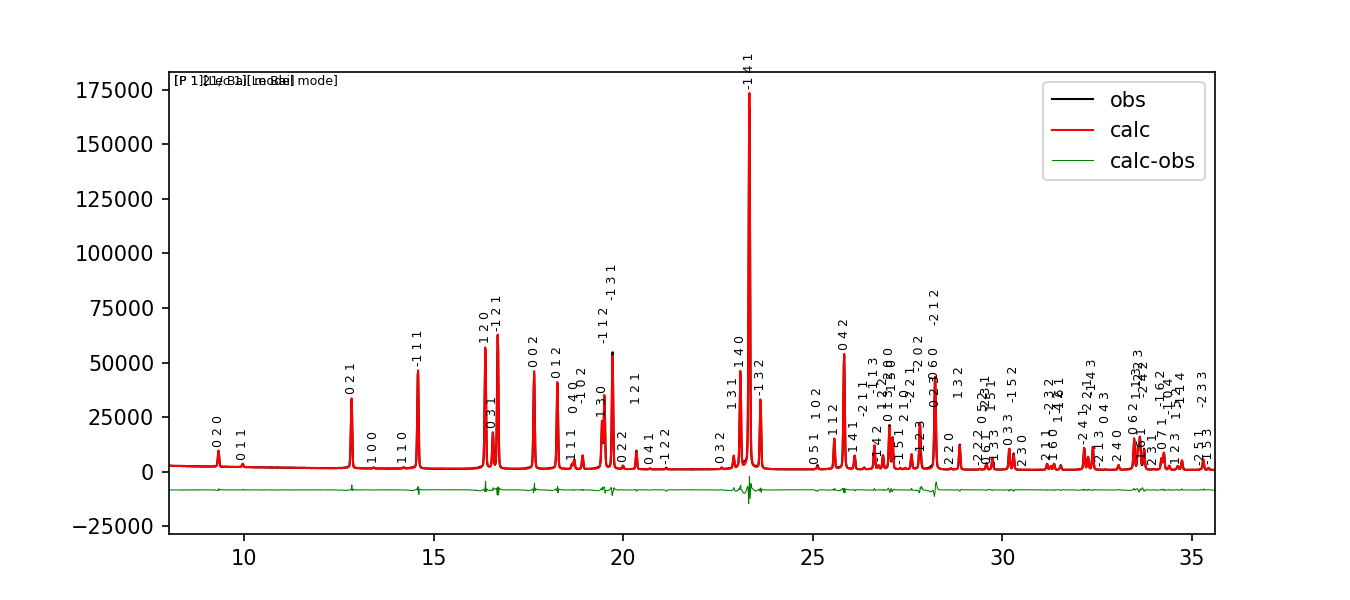

In [6]:
p.SetMaxSinThetaOvLambda(0.2)  # Important for stability of profile fit. And faster !
spgex = SpaceGroupExplorer(pdiff)

# NB:verbose C++ output does not appear in a notebook
spgex.RunAll(keep_best=True, update_display=False, fitprofile_p1=False)

for sol in spgex.GetScores():
    #if sol.nGoF > 4 * spgex.GetScores()[0].nGoF:
    if sol.GoF <= 2 * spgex.GetScores()[0].GoF:
        print(sol)

print("Chosen spacegroup (smallest nGoF): ", c.GetSpaceGroup())

# Updated plot with optimal spacegroup
p.plot(diff=True, fig=None, hkl=True, reset=True)

### Add Cimetidine molecule to the crystal structure
This is imported from a Fenske-Hall z-matrix, downloaded as needed.

We can also look at options, and disable the Dynamical Occupancy Correction, because we don't expect the molecule atoms to be overlapping with each other.

In [7]:
if not os.path.exists("cime.fhz"):
    os.system("curl -O https://raw.githubusercontent.com/vincefn/objcryst/master/Fox/example/tutorial-cimetidine/cime.fhz")

# This will automatically add the Molecule to the Crystal object
m = ImportFenskeHallZMatrix(c,"cime.fhz")
print("Crystal Formula:", c.GetFormula())
print()

# List the options to see which are available
for i in range(c.GetNbOption()):
    o = c.GetOption(i)
    print("Option #%d: %s = %s"% (i, o.GetName(), o.GetChoiceName(o.GetChoice())))
    for j in range (o.GetNbChoice()):
        print("   Choice %d: %s" %(j, o.GetChoiceName(j)))


c.GetOption(1).SetChoice(0)

Crystal Formula: C9 N6 S1

Option #0: Constrain Lattice to SpaceGroup Symmetry = Yes (Default)
   Choice 0: Yes (Default)
   Choice 1: No (Allow Crystallographic Pseudo-Symmetry)
Option #1: Use Dynamical Occupancy Correction = Yes
   Choice 0: No
   Choice 1: Yes
Option #2: Display Enantiomer = No
   Choice 0: No
   Choice 1: Yes


### Create a MonteCarlo object and add objects (crystal, powder pattern) for optimisation

In [8]:
mc = MonteCarlo()
mc.AddRefinableObj(c)
mc.AddRefinableObj(p)

### Disable profile fitting before Monte-Carlo
..or else the crystal structure will not be optimised

<IPython.core.display.Javascript object>


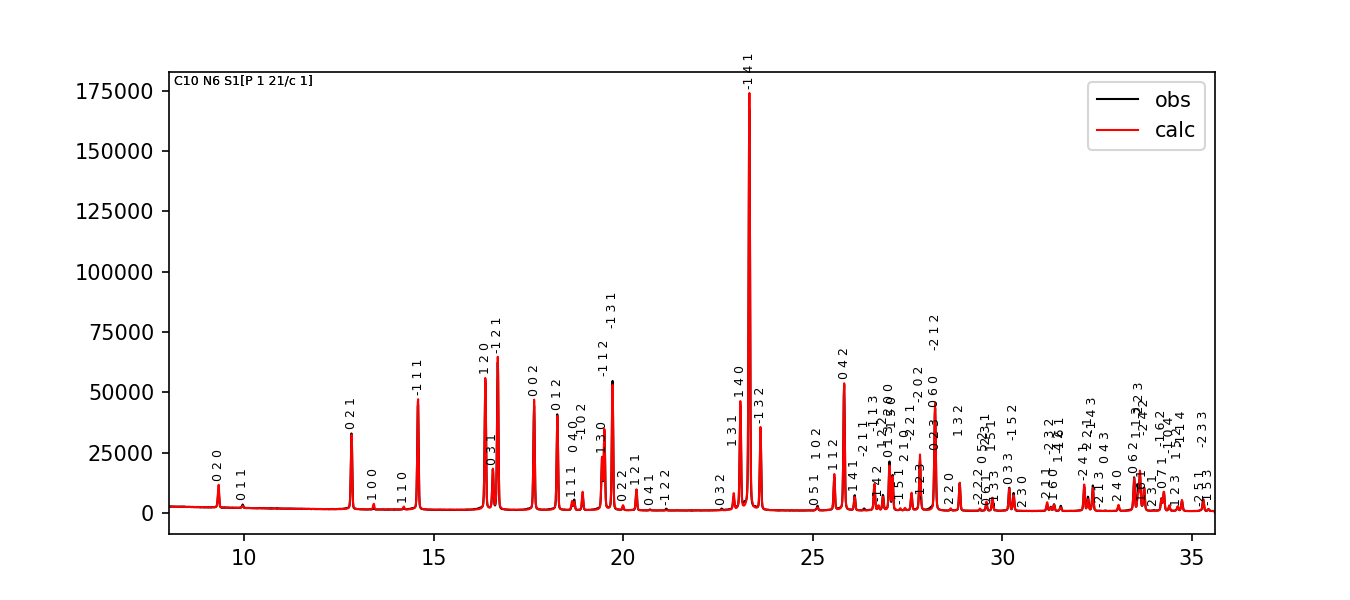

In [9]:
pdiff.SetExtractionMode(False)
p.FitScaleFactorForRw() # for a better initial display
p.plot(fig=None,diff=False,hkl=True)

### Run multiple optimisations
We also enable the automatic least squares every 150k trials, which allows a better convergence

We perform 3 runs, each of 500k trials using parallel tempering, with default parameters (which should be adequate for all problems). Normally for this structure it would be better to use 1 or 2 millions trials to be almost sure that the correct solution will be found during every run.

Each run starts from a randomised configuration.

In [10]:
mc.GetOption("Automatic Least Squares Refinement").SetChoice(2)
print("LSQ option: ", mc.GetOption("Automatic Least Squares Refinement").GetChoiceName(2))

# The above plot should be updated with new best solution during each run
mc.MultiRunOptimize(nb_run=3, nb_step=5e5)
print("Final LLK: %.2f" % mc.GetLogLikelihood())

LSQ option:  Every 150000 trials, and at the end of each run
Run  0  Trial    39600  LLK=  1463004.63
Run  0  Trial    78900  LLK=  1242367.50
Run  0  Trial   118200  LLK=  1218161.31
Run  0  Trial   150000  LLK=   192352.10
Run  0  Trial   300000  LLK=   181575.10
Run  0  Trial   450000  LLK=   127769.13
Run  0  Trial   489300  LLK=   127769.13
Run  0  Trial   500100  LLK=   127769.13
Run  1  Trial    39300  LLK=  1456247.61
Run  1  Trial    78900  LLK=  1222890.64
Run  1  Trial   118500  LLK=  1152257.75
Run  1  Trial   150000  LLK=   163821.79
Run  1  Trial   450000  LLK=   123823.10
Run  1  Trial   500100  LLK=   118353.16
Run  2  Trial    39300  LLK=  1219212.82
Run  2  Trial    78900  LLK=  1088220.37
Run  2  Trial   117900  LLK=  1058075.74
Run  2  Trial   150000  LLK=   217225.63
Run  2  Trial   189600  LLK=   217225.63
Run  2  Trial   300000  LLK=    21048.19
Run  2  Trial   450000  LLK=    20901.53
Run  2  Trial   500100  LLK=    20901.53
MonteCarlo: current LLK=    18436.56


### List solutions
All solutions are stored in a "Parameter Set" which can be restored (assuming that the objects - crystal structure and powder pattern are not altered e.g. by changing the list of atoms, the profile, or the fixed parameters etc...).

This will only record changes of parameters such as atom coordinates, but will not record other changes such as a different spacegroup, or a change of the Scatterers (number of atoms or molecules) inside a Crystal. It can only be used to browse results obtained at the end of `MultiRunOptimize()`.

At the end of the optimisation the best solution is automatically restored.

In [11]:
for i in range(mc.GetNbParamSet()):
    idx = mc.GetParamSetIndex(i)
    cost = mc.GetParamSetCost(i)
    name = mc.GetFullRefinableObj().GetParamSetName(idx)
    print("%3d: LLK=%10.2f, name=%s"%(idx, cost, name))

  0: LLK=  20901.00, name=Best Configuration
  1: LLK= 127769.00, name=Run #3
  2: LLK= 118353.00, name=Run #2
  3: LLK=  20901.00, name=Run #1


### Restore a chosen solution (set of parameters)

<IPython.core.display.Javascript object>


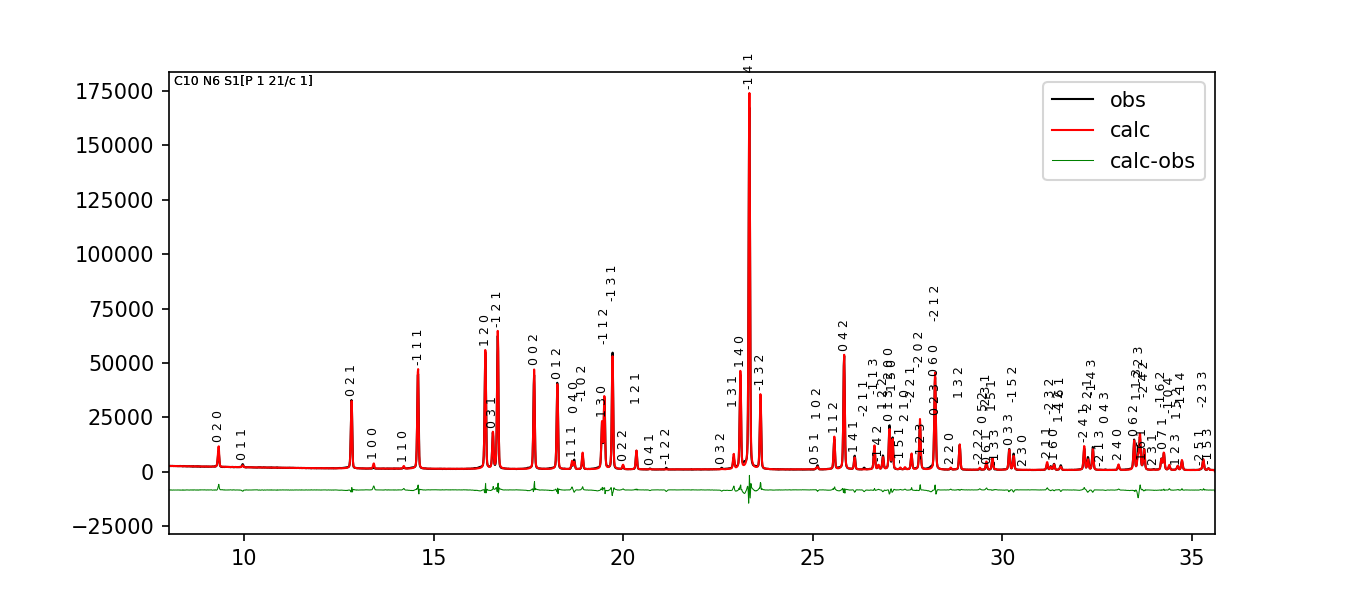

MonteCarlo: current LLK=    18436.56


In [12]:
p.plot(fig=None, diff=True)
mc.RestoreParamSet(0, update_display=True)

### Save results to CIF and Fox (.xmlgz) formats

In [13]:
# Save result so it can be opened by Fox
xml_cryst_file_save_global('result.xmlgz')
# Also export to the CIF format
c.CIFOutput("result.cif")

### 3D Crystal view ?
Still TODO... But you can play with e.g. `py3dmol` using the CIF output.

In [ ]:
if False:
    # 'pip install py3dmol' or 'conda install --no-deps -c conda-forge py3dmol'
    import py3Dmol
    v=py3Dmol.view()
    v.addModel(c.CIF(),'cif')
    v.setStyle({'stick':{}}) # Use 'sphere' for atoms
    v.addUnitCell()
    v.zoomTo()
    v.show()